# Class Practice 

In [234]:
import librosa 
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
import IPython.display as ipd
import random

# below found from https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
import torch
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [235]:
audio_files = pd.read_csv('audio_files.csv')

In [236]:
class AudioTransformer:

    max_len = 50000

    def __init__(self, aud):
        self.aud = aud
        self.sig = aud[0]
        self.sr = aud[1]
        self.S_dB = None
        self.augmented_melspec = None

    def open_audio(self):
        self.sig, self.sr = librosa.load(self.aud, sr=22050, mono=True)
        return (self.sig, self.sr)

    def same_length(self):
        sig_len = len(self.sig)
        
        if (sig_len > self.max_len):
            self.sig = sig[:self.max_len]
            
        elif (sig_len < self.max_len):
            diff = self.max_len - sig_len
            for i in range(0, diff):
                self.sig = np.append(self.sig, 0)
        return (self.sig, self.sr)

    def time_shift(self):
        shift = int(random.random() * len(self.sig))
        self.sig = np.roll(self.sig, shift)
        return (self.sig, self.sr)

    def to_spectrogram(self):
        S = librosa.feature.melspectrogram(y=self.sig, sr=self.sr, n_mels=128, fmax=8000)
        self.S_dB = librosa.power_to_db(S, ref=np.max)
        return (self.S_dB)

    def aug_sepctrogram(self, max_mask_pct=0.1):
        freq, time = self.S_dB.shape
        self.augmented_melspec = self.S_dB.copy()
        freq_mask_param = max_mask_pct * freq
        time_mask_param = max_mask_pct * time

        # Code copied and edited from 
        # https://www.kaggle.com/code/davids1992/specaugment-quick-implementation
        
        # Frequency masking
        num_freqs_to_mask = int(freq_mask_param * random.uniform(0.5, 1.5))
        f0 = int(np.random.uniform(low = 0.0, high = (freq - num_freqs_to_mask)))
        self.augmented_melspec[:, f0:(f0 + num_freqs_to_mask)] = 0
        # Time masking
        num_frames_to_mask = int(time_mask_param * random.uniform(0.5, 1.5))
        t0 = int(np.random.uniform(low = 0.0, high = (time - num_frames_to_mask))) 
        self.augmented_melspec[t0:(t0 + num_frames_to_mask), :] = 0
        
        return self.augmented_melspec    


    

In [ ]:
class SoundDS(Dataset, AudioTransformer):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)

In [207]:
aud = AudioTransformer('./audio_files/Major/Major_14.wav')

In [208]:
aud.open_audio()

(array([-0.00417987, -0.0072336 , -0.00686302, ...,  0.        ,
         0.        ,  0.        ], dtype=float32),
 22050)

In [209]:
len(aud.sig)

49613

In [210]:
aud.same_length()

(array([-0.00417987, -0.0072336 , -0.00686302, ...,  0.        ,
         0.        ,  0.        ]),
 22050)

In [211]:
len(aud.sig)

50000

In [212]:
aud.time_shift()[0]

array([-0.36181533, -0.38614962, -0.38785923, ..., -0.19787405,
       -0.26125929, -0.31809431])

In [213]:
aud.to_spectrogram()

array([[-28.89337529, -29.30090881, -30.81258143, ..., -24.96281878,
        -26.59259358, -29.5483308 ],
       [-30.20599747, -31.29170477, -31.88413942, ..., -24.60487479,
        -28.45720549, -25.73152397],
       [-29.20876613, -30.46640793, -31.45494321, ..., -21.58733045,
        -25.07254542, -22.39471643],
       ...,
       [-50.1324258 , -56.12306483, -69.83887481, ..., -80.        ,
        -72.89991573, -52.50353982],
       [-50.26035558, -56.20937045, -67.91059183, ..., -80.        ,
        -73.04562544, -52.64643902],
       [-50.38092741, -56.38192767, -72.85031672, ..., -80.        ,
        -73.16822494, -52.77505385]])

In [232]:
aud.aug_sepctrogram()

array([[-28.89337529, -29.30090881, -30.81258143, ..., -24.96281878,
        -26.59259358, -29.5483308 ],
       [-30.20599747, -31.29170477, -31.88413942, ..., -24.60487479,
        -28.45720549, -25.73152397],
       [-29.20876613, -30.46640793, -31.45494321, ..., -21.58733045,
        -25.07254542, -22.39471643],
       ...,
       [-50.1324258 , -56.12306483, -69.83887481, ..., -80.        ,
        -72.89991573, -52.50353982],
       [-50.26035558, -56.20937045, -67.91059183, ..., -80.        ,
        -73.04562544, -52.64643902],
       [-50.38092741, -56.38192767, -72.85031672, ..., -80.        ,
        -73.16822494, -52.77505385]])

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

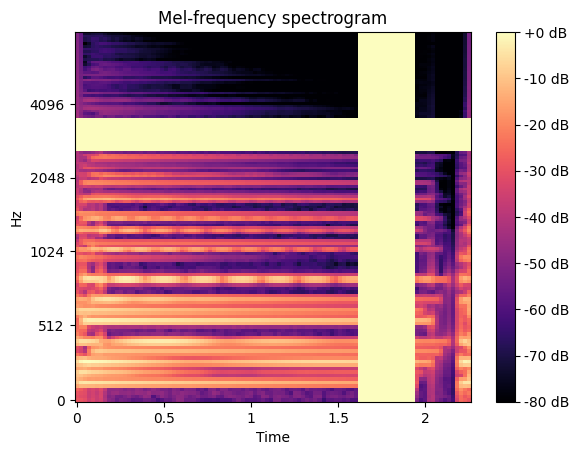

In [233]:
fig, ax = plt.subplots()
img = librosa.display.specshow(aud.augmented_melspec, x_axis='time',
                         y_axis='mel', sr=aud.sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')